In [1]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt, patheffects as pe, ticker
from matplotlib.axes import Axes
import numpy as np
import seaborn as sns

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment
from scripts.utils import build_true_dict, extract_smis

sns.set_theme("talk", "white")
sns.set_palette("dark")

HTS_DIR = Path.home() / "active-projects/molpal-pruning/runs/HTS/full/al/0.004"
HTS_SB_DIR = Path.home() / "active-projects/molpal-pruning/runs/HTS/full/sb"

SIZE = 2.1e6
k = 1000

d_smi_score = build_true_dict("../data/EnamineHTS_scores.csv")

smis = extract_smis("../libraries/EnamineHTS.csv")
y_true = np.array([d_smi_score.get(smi) for smi in smis], float)

hts_top_k = sorted(
    d_smi_score.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:k]

In [2]:
def plot_reward(ax, x, y, yerr, ls="-", alpha=1):
    ax.errorbar(
        x, y, yerr,
        fmt='o', ls=ls, color="darkgreen", mec="k", mew=2,
        capsize=5, capthick=2,
        alpha=alpha
    )

def annotate_ax(ax: Axes, x, y):
    ax.annotate(
        f"{y:0.3f}", xy=(x, y), xytext=(-60, -15),
        textcoords="offset points",
        fontsize=12, arrowprops=dict(arrowstyle="->")
    )


/home/degraff/molpal/notebooks/../scripts/experiment.py:28: UserWarning: Experiment has no checkpoints!
  warnings.warn("Experiment has no checkpoints!")
/home/degraff/molpal/notebooks/../scripts/experiment.py:28: UserWarning: Experiment has no checkpoints!
  warnings.warn("Experiment has no checkpoints!")


SB-0.004: 0.950
SB-0.020: 0.763
AL-0.004: 0.979


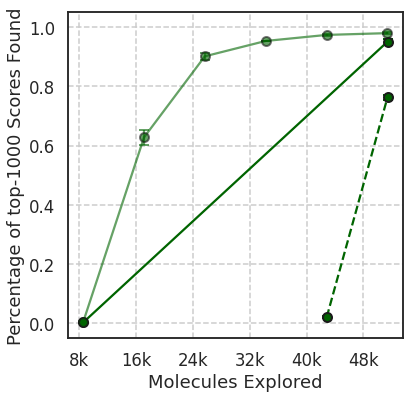

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

rs = []
for e in (HTS_SB_DIR / "0.004").iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0))
print(f"SB-0.004: {R.mean(0)[-1]:0.3f}")

rs = []
for e in (HTS_SB_DIR / "0.020").iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0), "--")
print(f"SB-0.020: {R.mean(0)[-1]:0.3f}")

rs = []
for e in HTS_DIR.iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0), "-", 0.6)
print(f"AL-0.004: {R.mean(0)[-1]:0.3f}")

ax.grid(True, "major", "both", ls="--")

ax.set_ylabel(f"Percentage of top-{k} Scores Found")
ax.set_xlabel("Molecules Explored")

ax.set_ylim(-0.05, 1.05)
ax.xaxis.set_major_formatter(ticker.EngFormatter(sep=""))
ax.xaxis.set_major_locator(ticker.MultipleLocator(8000))

In [10]:
fig.savefig("../figures/hts/single-batch.png", dpi=400, bbox_inches="tight")

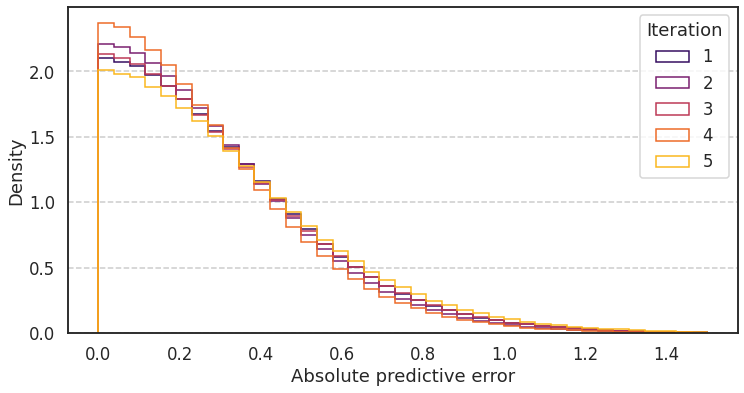

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

e = Experiment(next(HTS_DIR.iterdir()))

iters = list(range(1, e.num_iters))[::-1]

errors = []
for i in iters:
    y_pred, _ = e.predictions(i)
    errors.append(np.abs(y_true - y_pred))

ax.hist(
    errors, np.linspace(0, 1.5, 40),
    color=sns.color_palette("inferno", len(errors))[::-1],
    histtype="step", density=True, label=iters
)

ax.legend(title="Iteration")

ax.set_ylabel("Density")
ax.set_xlabel("Absolute predictive error")
ax.grid(True, "major", "y", ls="--")

In [66]:
fig.savefig("../figures/hts/errors-hist.pdf", dpi=400, bbox_inches="tight")